In [1]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices: tf.config.experimental.set_memory_growth(device, True)


### Import necessary libraries

In [2]:
import numpy as np
import os
import itertools
import matplotlib.pyplot as plt
import json
import seaborn as sns

%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, Activation, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from PIL import Image, ImageChops, ImageEnhance
from tqdm.notebook import tqdm

### Error Level Analysis

In [3]:
#converts input image to ela applied image
def convert_to_ela_image(path,quality):

    original_image = Image.open(path).convert('RGB')

    #resaving input image at the desired quality
    resaved_file_name = 'resaved_image.jpg'     #predefined filename for resaved image
    original_image.save(resaved_file_name,'JPEG',quality=quality)
    resaved_image = Image.open(resaved_file_name)

    #pixel difference between original and resaved image
    ela_image = ImageChops.difference(original_image,resaved_image)
    
    #scaling factors are calculated from pixel extremas
    extrema = ela_image.getextrema()
    max_difference = max([pix[1] for pix in extrema])
    if max_difference ==0:
        max_difference = 1
    scale = 350.0 / max_difference
    
    #enhancing elaimage to brighten the pixels
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    ela_image.save("ela_image.png")
    return ela_image

### Dataset Preparation

In [4]:
def prepare_image(image_path):
    image_size = (128, 128)
    return np.array(convert_to_ela_image(image_path, 90).resize(image_size)).flatten() / 255.0         #normalizing the array values obtained from input image

In [5]:
X = [] # ELA converted images
Y = [] # 0 for fake, 1 for real

In [6]:
#adding authentic images

path = r'C:\Users\parth\Downloads\cnn\kaggle\input\casia-dataset\CASIA1\Au'       #folder path of the authentic images in the dataset
for filename in tqdm(os.listdir(path),desc="Processing Images : "):
    if filename.endswith('jpg') or filename.endswith('png'):
        full_path = os.path.join(path, filename)
        X.append(prepare_image(full_path))        
        Y.append(1)     # label for authentic images 
        
print(f'Total images: {len(X)}\nTotal labels: {len(Y)}')

Processing Images :   0%|          | 0/800 [00:00<?, ?it/s]

Total images: 790
Total labels: 790


In [7]:
#adding forged images

path = r'C:\Users\parth\Downloads\cnn\kaggle\input\casia-dataset\CASIA1\Sp'       #folder path of the forged images in the dataset
for filename in tqdm(os.listdir(path),desc="Processing Images : "):
    if filename.endswith('jpg') or filename.endswith('png'):
        full_path = os.path.join(path, filename)
        X.append(prepare_image(full_path))        
        Y.append(0)     # label for forged images 
        
print(f'Total images: {len(X)}\nTotal labels: {len(Y)}')

Processing Images :   0%|          | 0/921 [00:00<?, ?it/s]

Total images: 1711
Total labels: 1711


In [8]:
X = np.array(X)
Y = np.array(Y)
X = X.reshape(-1, 128, 128, 3) 

### Partitioning dataset for training, validation and testing

In [9]:
# Training : Validation : Testing = 76 : 19 : 5
X_temp, X_test, Y_temp, Y_test = train_test_split(X, Y, test_size = 0.05, random_state=5)
X_train, X_val, Y_train, Y_val = train_test_split(X_temp, Y_temp, test_size = 0.2, random_state=5)
X = X.reshape(-1,1,1,1)

print(f'Training images: {len(X_train)} , Training labels: {len(Y_train)}')
print(f'Validation images: {len(X_val)} , Validation labels: {len(Y_val)}')
print(f'Test images: {len(X_test)} , Test labels: {len(Y_test)}')

Training images: 1300 , Training labels: 1300
Validation images: 325 , Validation labels: 325
Test images: 86 , Test labels: 86


### CNN Model

In [10]:
def build_model():
    model = Sequential()  # Sequential Model
    model.add(Conv2D(filters = 64, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(Conv2D(filters = 64, kernel_size = (5, 5), padding = 'valid', activation = 'relu'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Conv2D(filters = 64, kernel_size = (5, 5), padding = 'valid', activation = 'relu'))
    model.add(Conv2D(filters = 64, kernel_size = (5, 5), padding = 'valid', activation = 'relu'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Conv2D(filters = 64, kernel_size = (5, 5), padding = 'valid', activation = 'relu'))
    model.add(Conv2D(filters = 64, kernel_size = (5, 5), padding = 'valid', activation = 'relu'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation = 'sigmoid'))
    return model

In [11]:
model = build_model()
model.summary()

c:\Users\parth\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 124, 124, 64)   │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 120, 120, 64)   │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 60, 60, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 52, 52, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 22, 22, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 18, 18, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 5, 5, 32)       │        51,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 568,449 (2.17 MB)

 Trainable params: 568,449 (2.17 MB)

 Non-trainable params: 0 (0.00 B)

### Model Training

In [12]:
epochs = 15
batch_size = 32


In [13]:
#Optimizer
init_lr = 0.0001   #learning rate for the optimizer
optimizer = Adam(lr = init_lr, decay = init_lr/15) 
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [14]:
#Early Stopping
early_stopping = EarlyStopping(monitor = 'val_accuracy',
                               min_delta = 0,
                               patience = 10,
                               verbose = 0,
                               mode = 'auto')

In [15]:
hist = model.fit(X_train,
                 Y_train,
                 batch_size = batch_size,
                 epochs = epochs,
                 validation_data = (X_val, Y_val),
                 callbacks = [early_stopping])

Epoch 1/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 156s 4s/step - accuracy: 0.5553 - loss: 0.6901 - val_accuracy: 0.6277 - val_loss: 0.6537
Epoch 2/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 157s 4s/step - accuracy: 0.6417 - loss: 0.6509 - val_accuracy: 0.6862 - val_loss: 0.6070
Epoch 3/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 199s 4s/step - accuracy: 0.6482 - loss: 0.6383 - val_accuracy: 0.7108 - val_loss: 0.6228
Epoch 4/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 174s 4s/step - accuracy: 0.6924 - loss: 0.6046 - val_accuracy: 0.7231 - val_loss: 0.5629
Epoch 5/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 159s 4s/step - accuracy: 0.7166 - loss: 0.5566 - val_accuracy: 0.7231 - val_loss: 0.5650
Epoch 6/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 155s 4s/step - accuracy: 0.7411 - loss: 0.5452 - val_accuracy: 0.7631 - val_loss: 0.5501
Epoch 7/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 156s 4s/step - accuracy: 0.7559 - loss: 0.5177 - val_accuracy: 0.6892 - val_loss: 0.6049
Epoch 8/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 155s 4s/step - accuracy: 0.7001 - loss: 0.5890 - val_accuracy: 0.7508 - v

In [18]:
#save the model as a h5 file
model.save('model_test.h5') 

# get the dictionary containing each metric and the loss for each epoch
history_dict = hist.history

# save it as a json file
json.dump(history_dict, open('model_hist.json', 'w'))

### Plotting the training and validation curves

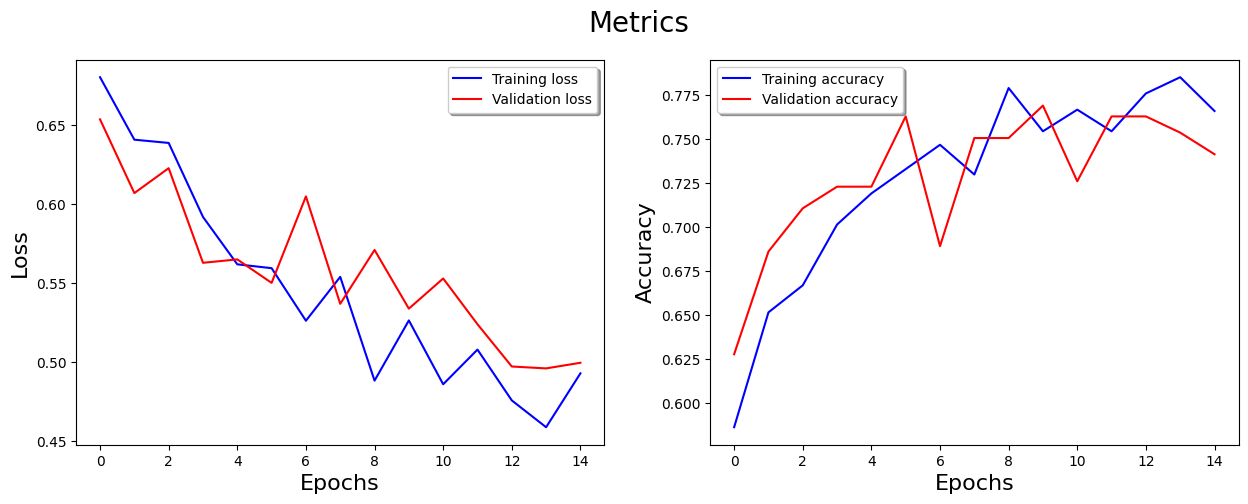

In [19]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

#Figure 1
ax[0].plot(history_dict['loss'], color='b', label = "Training loss")
ax[0].plot(history_dict['val_loss'], color='r', label = "Validation loss",axes =ax[0])
ax[0].set_xlabel('Epochs',fontsize=16)
ax[0].set_ylabel('Loss',fontsize=16)
legend = ax[0].legend(loc='best', shadow=True)

#Figure 2
ax[1].plot(history_dict['accuracy'], color='b', label = "Training accuracy")
ax[1].plot(history_dict['val_accuracy'], color='r',label = "Validation accuracy")
ax[1].set_xlabel('Epochs',fontsize=16)
ax[1].set_ylabel('Accuracy',fontsize=16)
legend = ax[1].legend(loc='best', shadow=True)

fig.suptitle('Metrics',fontsize=20);

### Confusion Matrix

In [20]:
def plot_confusion_matrix(cf_matrix):
  
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()] #number of images in each classification block
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)] #percentage value of images in each block w.r.t total images

    axes_labels=['Forged', 'Authentic']
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='',cmap="flare" , xticklabels=axes_labels, yticklabels=axes_labels)

    plot_xlabel = plt.xlabel('Predicted labels', fontsize = 13)
    plot_ylabel = plt.ylabel('True labels', fontsize = 13)
    plot_title = plt.title('Confusion Matrix', fontsize= 10,fontweight='bold')

11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 752ms/step


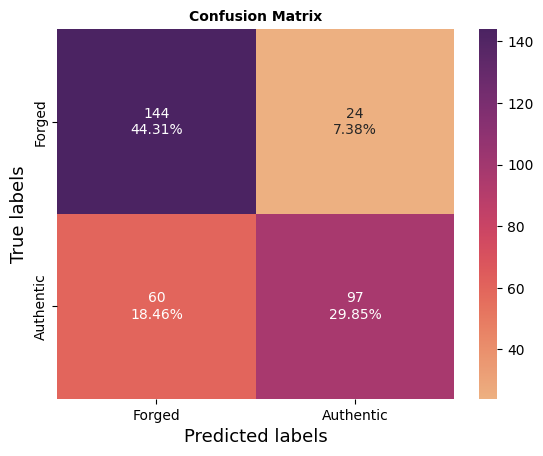

In [21]:
Y_pred = model.predict(X_val)               # Predict the values from the validation dataset 
Y_pred_classes = np.round(Y_pred)           # roundoff the sigmoid value
Y_true = Y_val                             

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)     # compute the confusion matrix
plot_confusion_matrix(confusion_mtx)                         # plot the confusion matrix


### Classification Report

In [22]:
print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.71      0.86      0.77       168
           1       0.80      0.62      0.70       157

    accuracy                           0.74       325
   macro avg       0.75      0.74      0.74       325
weighted avg       0.75      0.74      0.74       325



### Testing Accuracy

In [23]:
class_names = ['Forged', 'Authentic']

In [24]:
# Testing accuracy
correct_test = 0 #correctly predicted test images
total_test = 0   #total test images

for index,image in enumerate(tqdm(X_test,desc="Processing Images : ")):
    image = image.reshape(-1, 128, 128, 3)
    y_pred = model.predict(image)
    y_pred_class = np.round(y_pred)
    total_test += 1
    if y_pred_class == Y_test[index]: #if prediction is correct
        correct_test += 1
    
print(f'Total test images: {total_test}\nCorrectly predicted images: {correct_test}\nAccuracy: {correct_test / total_test * 100.0} %')

Processing Images :   0%|          | 0/86 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━

# Test an image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediction: Forged
Confidence:  96.21%
--------------------------------------------------------------------------------------------------------------


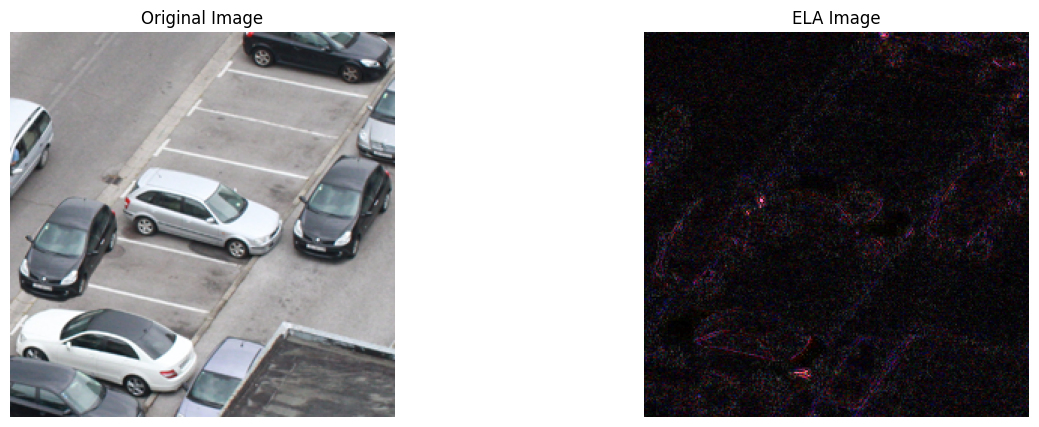

In [26]:
test_image_path = r'C:\Users\parth\Downloads\cnn\image-forgery-detection-main\forged1.png'    # test image path
test_image = prepare_image(test_image_path)
test_image = test_image.reshape(-1, 128, 128, 3)

y_pred = model.predict(test_image)
y_pred_class = round(y_pred[0][0])

fig, ax = plt.subplots(1,2,figsize=(15,5)) 

#display original image
original_image = plt.imread(test_image_path) 
ax[0].axis('off')
ax[0].imshow(original_image)
ax[0].set_title('Original Image')

#display ELA applied image
ax[1].axis('off')
ax[1].imshow(convert_to_ela_image(test_image_path,90)) 
ax[1].set_title('ELA Image')

print(f'Prediction: {class_names[y_pred_class]}')
if y_pred<=0.5:
    print(f'Confidence:  {(1-(y_pred[0][0])) * 100:0.2f}%')
else:
    print(f'Confidence: {(y_pred[0][0]) * 100:0.2f}%')
print('--------------------------------------------------------------------------------------------------------------')

# Test a dataset

In [31]:
test_folder_path = r'C:\Users\parth\Downloads\cnn\kaggle\input\casia-dataset\CASIA1\Sp'        #dataset path
authentic,forged,total = 0,0,0

for filename in tqdm(os.listdir(test_folder_path),desc="Processing Images : "):
    if filename.endswith('jpg') or filename.endswith('png'):
        test_image_path = os.path.join(path, filename)
        test_image = prepare_image(test_image_path)  
        test_image.reshape(-1, 128, 128, 3)
        y_pred = model.predict(image)
        y_pred_class = np.round(y_pred)
        total += 1
        if y_pred_class == 0:
            forged += 1
        else:
            authentic +=1

print(f'Total images: {total}\nAuthentic Images: {authentic}\nForged Images: {forged}')

Processing Images :   0%|          | 0/921 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━